In [24]:
# conda install -c conda-forge plotnine
#git clone https://github.com/has2k1/plotnine.git
#cd plotnine
#pip install -e
# Pacotes
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.datasets import co2, get_rdataset

from plotnine import *

from statsmodels.tsa.seasonal import seasonal_decompose, STL

from statsmodels.tsa.filters.hp_filter import hpfilter

from statsmodels.tsa.stattools import adfuller, kpss

In [25]:
# Dataset: AirPassengers
air_passengers = get_rdataset("AirPassengers")
airp_df = air_passengers.data
airp_df.index = pd.date_range('1949', '1961', freq='M')
airp_df.drop(columns=['time'], inplace=True)

In [26]:
# Dataset: co2
co2_df = co2.load_pandas().data
co2_df = co2_df.ffill()

# DETECTANDO ESTACIONARIEDADE: 
    - Várias técnicas de previsão de séries temporais assumem estacionaridade. um processo não estacionário é mais complexo de modelar devido à natureza dinâmica e variações ao longo do tempo (por exemplo, na presença de tendência ou sazonalidade)
    - uma série temporal estacionária é definida como uma série temporal com uma média constante (μ), uma variância constante (σ2) e uma covariância consistente (ou autocorrelação) entre períodos distanciados idênticos (lags).

# Testes estatísticos
    -  ADF: a hipótese nula afirma que existe uma raiz unitária na série temporal e, portanto, é não estacionária. 
    -  KPSS: tem a hipótese nula oposta, que assume que a série temporal é estacionária.  

In [27]:
# A função obtém a saída das funções adfuller e kpss e retorna um dicionário que adiciona rótulos à saída.

def print_results(output, test='adf'):    
    pval = output[1]
    test_score = output[0]
    lags = output[2]    
    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'            
    output_dict = {
    'Test Statistic': test_score,
    'p-value': pval,
    'Numbers of lags': lags,
    'decision': decision
    }
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value
       
    return pd.Series(output_dict, name=test)

In [28]:
adf_output = adfuller(co2_df)
kpss_output = kpss(co2_df)

c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.



In [29]:
# Concatena os resultados de ambos os testes
pd.concat([print_results(adf_output, 'adf'),print_results(kpss_output, 'kpss')], axis=1)

# Essencialmente, a estacionariedade pode ser alcançada removendo os efeitos de tendência (sem tendência) e de sazonalidade. Para cada 
# transformação, você executará os testes de estacionaridade e comparará os resultados entre as diferentes técnicas. Para simplificar a 
# interpretação e comparação, você criará duas funções:

,adf,kpss
Test Statistic,0.046051,7.649196
p-value,0.962179,0.01
Numbers of lags,27,29
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.433252,0.739
Critical Value (5%),-2.862822,0.463
Critical Value (10%),-2.567452,0.347
Critical Value (2.5%),NaN,0.574


In [30]:
def check_stationarity(df):
    kps = kpss(df)
    adf = adfuller(df)
    
    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Stationary', 'Non-stationary'
    
    if adf_pv < 0.05:
        # Reject ADF Null Hypothesis
        adfh = 'Stationary'
    if kpss_pv < 0.05:
        # Reject KPSS Null Hypothesis
        kpssh = 'Non-stationary'
    return (kpssh, adfh)    

In [31]:
def plot_comparison(methods, plot_type='line'):
    n = len(methods) // 2
    fig, ax = plt.subplots(n,2, sharex=True, figsize=(20,10))
    for i, method in enumerate(methods):
        method.dropna(inplace=True)
        name = [n for n in globals() if globals()[n] is method]
        v, r = i // 2, i % 2
        kpss_s, adf_s = check_stationarity(method)
        method.plot(kind=plot_type, 
                    ax=ax[v,r], 
                    legend=False, 
                    title=f'{name[0]} --> KPSS: {kpss_s}, ADF {adf_s}')
        ax[v,r].title.set_size(20)
        method.rolling(52).mean().plot(ax=ax[v,r],legend=False)     

# TORNANDO UMA SÉRIE ESTACIONÁRIA
    - 1. Diferenciação de primeira ordem: é calculada subtraindo uma observação no tempo t da observação anterior no tempo t-1
    - 2. Diferenciação de segunda ordem: Isso é útil se houver sazonalidade ou se a diferenciação de primeira ordem for insuficiente. Isso é basicamente diferenciar duas vezes - diferenciar para remover a sazonalidade seguida de diferenciar para remover a tendência.
    - 3. Subtraindo a média móvel (janela contínua) da série temporal 
    - 4. A transformação de log: usando np.log() é uma técnica comum para estabilizar a variação em uma série temporal e, às vezes, o suficiente para tornar a série temporal estacionária. Simplesmente, tudo o que ele faz é substituir cada observação por seu valor logarítmico
    - 5. Usando a decomposição da série temporal para remover o componente de tendência, como sazonal_decompose. 
    - 6. Usando o filtro Hodrick-Prescott para remover o componente de tendência, por exemplo, usando hp_filter


In [32]:
# Primeira diferença
first_order_diff = co2_df.diff().dropna()

# Segunda diferença
differencing_twice = co2_df.diff(52).diff().dropna()

# Subtraindo a média móvel
rolling = co2_df.rolling(window=52).mean() # since it is weekly data
subtract_rolling_mean = co2_df - rolling

# Transformação logaritmica
log_transform = np.log(co2_df)

# Usando a decomposição
decomp = seasonal_decompose(co2_df)
sd_detrend = decomp.observed - decomp.trend

# Usando e Hodrick-Prescott filter
cyclic, trend = hpfilter(co2_df)


c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

c:\Users\Pc\anaconda3\lib\site-p

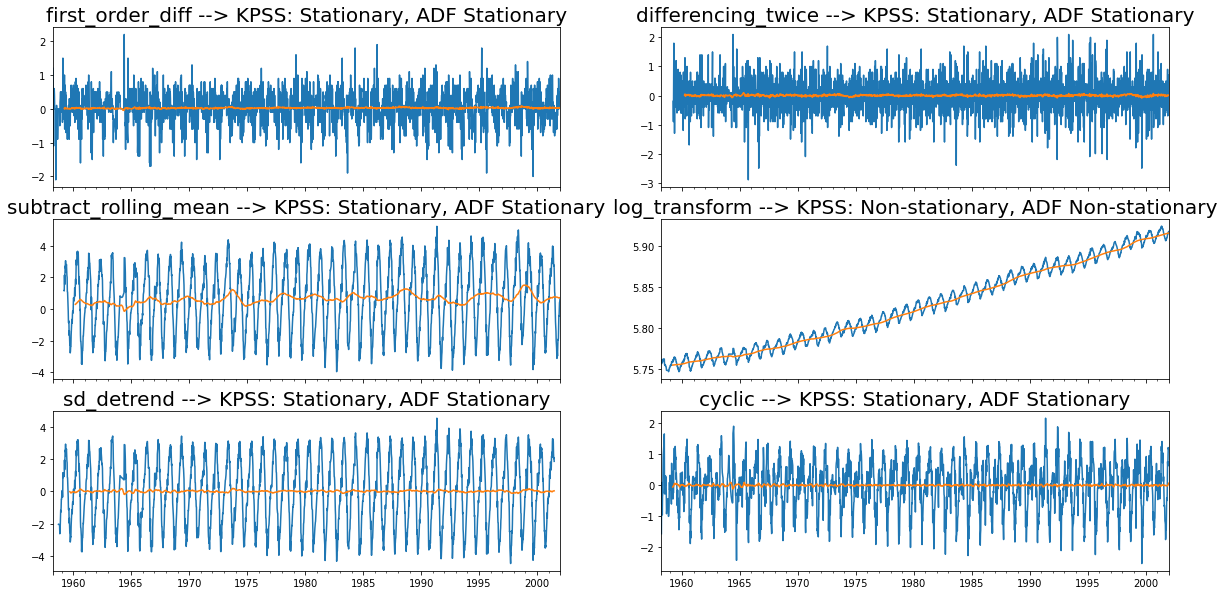

In [33]:
# Agora, vamos combinar os métodos em uma lista Python e passar a lista para a função plot_comparison:
methods = [first_order_diff, differencing_twice, 
           subtract_rolling_mean, log_transform,
           sd_detrend, cyclic]
plot_comparison(methods)

# Geralmente, você não deseja superdiferenciar suas séries temporais, pois alguns estudos mostraram que modelos baseados em dados superdiferenciados são menos precisos. 

In [36]:
# OLS utilizado no teste de hipótese
adf_result = adfuller(first_order_diff, store=True)
adf_result[-1].resols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     112.4
Date:                Mon, 28 Nov 2022   Prob (F-statistic):               0.00
Time:                        00:10:13   Log-Likelihood:                -1300.1
No. Observations:                2255   AIC:                             2658.
Df Residuals:                    2226   BIC:                             2824.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.2089      0.078    -15.517      0.000      -1.362      -1.056
x2             0.0694      0.074      0.934      0.351      -0.076       0.215
x3             0.0549      0.071      0.771      0.441      -0.085       0.194
x4             0.2661      0.068      3.894      0.000       0.132       0.400
x5             0.4363      0.066      6.603      0.000       0.307       0.566
x6             0.6273      0.064      9.780      0.000       0.502       0.753
x7             0.7159      0.063     11.377      0.000       0.592       0.839
x8             0.8211      0.062     13.246      0.000       0.699       0.943
x9             0.8455      0.061     13.779      0.000       0.725       0.966
x10            0.8269      0.061     13.641      0.000       0.708       0.946
x11            0.7763      0.060     13.011      0.000       0.659       0.893
x12            0.6904      0.058     11.815      0.000       0.576       0.805
x13            0.5949      0.057     10.486      0.000       0.484       0.706
x14            0.4798      0.055      8.736      0.000       0.372       0.588
x15            0.3971      0.053      7.466      0.000       0.293       0.501
x16            0.3136      0.052      6.074      0.000       0.212       0.415
x17            0.2572      0.050      5.096      0.000       0.158       0.356
x18            0.2521      0.050      5.082      0.000       0.155       0.349
x19            0.2443      0.049      4.982      0.000       0.148       0.341
x20            0.2534      0.049      5.211      0.000       0.158       0.349
x21            0.2867      0.048      5.940      0.000       0.192       0.381
x22            0.3286      0.048      6.864      0.000       0.235       0.422
x23            0.3501      0.047      7.426      0.000       0.258       0.443
x24            0.3452      0.046      7.504      0.000       0.255       0.435
x25            0.3440      0.044      7.904      0.000       0.259       0.429
x26            0.2724      0.039      6.924      0.000       0.195       0.350
x27            0.1844      0.032      5.846      0.000       0.123       0.246
x28            0.0940      0.021      4.493      0.000       0.053       0.135
const          0.0299      0.009      3.201      0.001       0.012       0.048
==============================================================================
Omnibus:                       57.058   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.961
Skew:                           0.023   Prob(JB):                     2.21e-29
Kurtosis:                       4.184   Cond. No.                         27.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is co